# PRiAD 4 - test zaliczający

Test obejmuje materiał z ćwiczenia PRiAD4, wymaga także znajmości zagadnień z wcześniejszych ćwiczeń.

In [12]:
# Import potrzebnych bibliotek operacji na ramkach danych
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# import bibliotek przydatnych do funkcji testowych
import random as rand

# import niezbędnych procedur uczenia
from scipy.cluster.hierarchy import linkage, dendrogram, ward, fcluster
from scipy.spatial.distance import cdist
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Procedury potrzebne do analizy wózka sklepowego
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Zmiana sposobu wyświetlania danych zmienno przecinkowych do dwóćh miejsc po przecinku
pd.options.display.float_format = "{:.2f}".format 

> **Zadanie 1** Wykonaj grupowanie danych zbioru `iris` metodą aglomeracyjną. Oszacuj na podstawie analizy otrzymanych danych (m.in. dendrogramu) jakia jest optymalna liczba grup i najlepszy typ odległości.

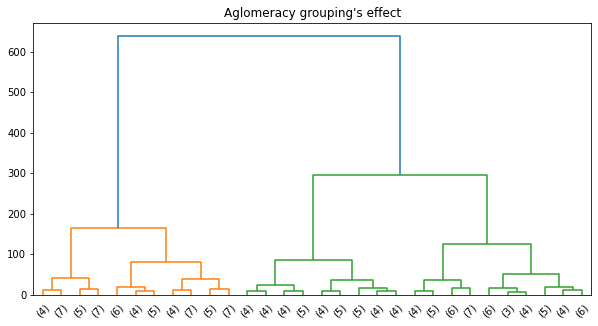

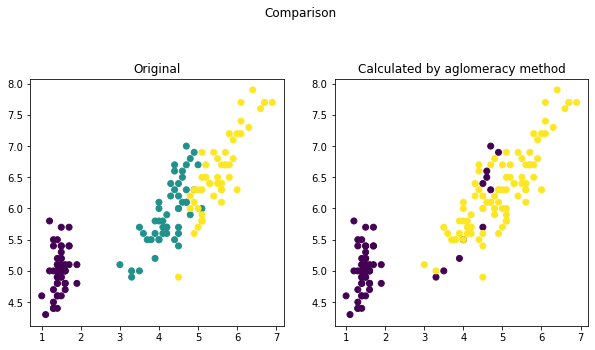

In [13]:
# Przygotowanie macierzy danych
irisDataOriginal = pd.read_csv("iris.csv")
irisData = irisDataOriginal.drop(columns = ['species'])

# Przygotowanie narzędzi do grupowania
groups = ward(irisData) #linkage(irisData, method = 'complete', metric = 'euclidean')
percTreshold = 70
threshold = percTreshold*max(groups[:, 2])/100

# Efekt grupowania
plt.figure(figsize = (10, 5))
plt.title('Aglomeracy grouping\'s effect')
plt.plot()
groupedIris = dendrogram(groups, truncate_mode = 'lastp', color_threshold = threshold)

# Porównanie oryginału i wyniku grupowania aglomeracyjnego
plt.figure(figsize = (10, 10))
plt.suptitle("Comparison")

# Oryginał
plt.subplot(2, 2, 1)
plt.title('Original')
plt.scatter(
    x = irisData['petal_length'], 
    y = irisData['sepal_length'], 
    c = irisDataOriginal['species'].astype('category').cat.codes
)

# Efekt grupowania
plt.subplot(2, 2, 2)
plt.title("Calculated by aglomeracy method")
irisData['species'] =  fcluster(groups, threshold, criterion = 'distance')
plt.scatter(
    x = irisData['petal_length'], 
    y = irisData['sepal_length'], 
    c = irisData['species']
)



Wnioski z analizy wyników zad. 1:
* Metoda grupowania aglomeracyjnego nie zdaje egzaminu w przypadku, gdy któreś dwie grupy są zbyt bardzo podobne do siebie. Nie rozpoznała poprawnie wszystkich 3 grup dla żadnego z możliwych parametrów wyznaczania odległości międzygrupowej.
* W przyrodzie jedynym dobrze wyróżniającym się gatunkiem irisów jest gatunek setosa. Został on poprawnie zakwalifikowany jako oddzielną grupę, ale pozostałe dwa gatunki są na tyle zbliżone do siebie, że nie udało się wyróżnić z nich dwóch oddzielnych grup.
* Dodatkowo w grupie zrzeszającej oba gatunki irysów pojawiły się artefakty grupy setosa. Jak widzimy na oryginale żaden obiekt z tego gatunku nie występuje w tamtym zakresie. Jest to dość poważny błąd. Takie artefakty przedstawione w poprzednim podpunkcie nie pojawiły się w przypadku wyznaczania odległości z wykorzystaniem maksymalnej odległości.


> **Zadanie 2** Napisz funkcję, która będzie wizualizować metodę sylwetki i łokciową dla dowolnego zbioru danych (z dowolną liczba atrybutów opisujących). Pierwszym argumentem tej funkcji powinien być zbiór (ramka) danych, drugim - zakres zmian k, trzecim - nazwy dwóch atrybutów wyświetlanych na wykresie punktowym obok wykresu sylwetki. 

In [19]:
def visualizeWithSilhouette(dataFrame, k, atributes):
    # Organizacja wydrukowanych w przyszłości wykresów
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    ax1.set_xlim([-0.6, 1])
    ax1.set_ylim([0, len(dataFrame) + (k + 1)*10])

    kmeans = KMeans(n_clusters = k, random_state = 0).fit(dataFrame)

    # Zdefiniowanie grup
    groupLabels = kmeans.fit_predict(
        dataFrame[ [atributes[0], atributes[1]] ]
    )

    # Miary sylwetek dla każdej z grup
    silhouette = silhouette_samples(
        dataFrame[ [atributes[0], atributes[1]] ],
        groupLabels
    )

    # Wartość średnia sylwetki
    averageSilhouette = silhouette_score(
        dataFrame[ [atributes[0], atributes[1]] ],
        groupLabels
    )

    linePos = 10
    for i in range(0, k):
        silhouetteInGroup = silhouette[groupLabels == 1]
        silhouetteInGroup.sort()

        groupPopulation = silhouetteInGroup.shape[0]

        ax1.fill_betweenx(
            np.arange(linePos, linePos + groupPopulation),
            0,
            silhouetteInGroup,
            color = cm.tab10(float(i)/k)
        )
        linePos += (groupPopulation + 10)
    
    ax1.set_title("Silhouette's chart")
    ax1.set_xlabel("Silhouette's value")
    ax1.set_ylabel("Group labels")

    # Wartość średnia sylwetki - rysunek
    ax1.axvline(
        x = averageSilhouette,
        color = 'blue',
        linestyle = "-"
    )

    ax1.set_xticks(
        [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]
    )
    ax1.set_yticks([])

    # Klastry - rysunek
    ax2.scatter(
        dataFrame[atributes[0]],
        dataFrame[atributes[1]],
        s = 30,
        lw = 0,
        alpha = 0.7,
        c = cm.tab10(groupLabels.astype(float)/k)
    )

    # Wizualne podsumowanie
    ax2.set_title("Data classification")
    ax2.set_xlabel(atributes[0])
    ax2.set_ylabel(atributes[1])
    plt.suptitle( ("Silhouette's analysis for k = %d" % k), fontweight = 'bold')
    description = (
        "Dla n = %d, average value of silhouette is equal to: %.3f, centroid-point distances sum is equal to: %.2f"
        % (k, averageSilhouette, kmeans.inertia_ )
    )
    plt.figtext(0.14, 0, description)
    plt.show()

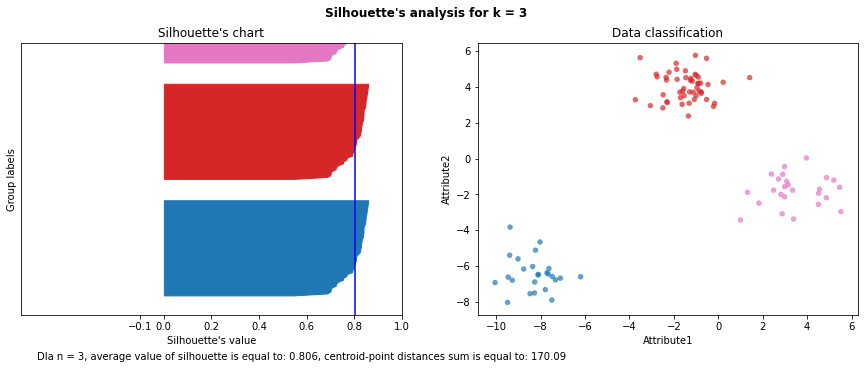

In [21]:
# kod skryptu prezerntującego działanie funkcji
X1, y1 = make_blobs(
    n_samples = 100, 
    n_features = 5, 
    centers = 4, 
    cluster_std = 1, 
    center_box = (-10.0, 10.0), 
    shuffle = True, 
    random_state = 1
)  

columns = ['Attribute' + str(x) for x in np.arange(1, X1.shape[1] + 1, 1)]
labels = {key: values for key, values in zip(columns, X1.T)}
labels['Label'] = y1
data = pd.DataFrame(labels).reindex(columns = columns + ['Label'])

visualizeWithSilhouette(data, 3, ['Attribute1', 'Attribute2'])



**Zadanie 3** Wykonaj grupowanie danych zbioru `iris` metodą k-średnich. Określ optymalne paramtery grupowania  (liczbę grup, typ odległości). Określ obiema metodami (łokciową i sylwetki) jakia jest dla optymalna liczba grup.

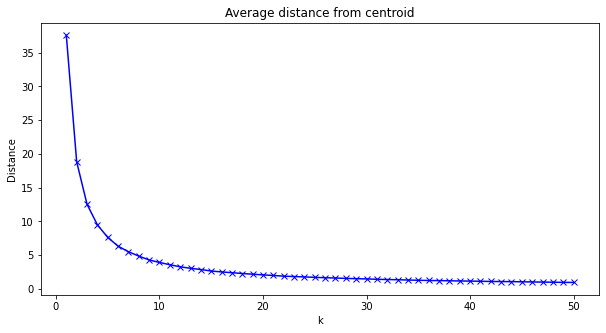

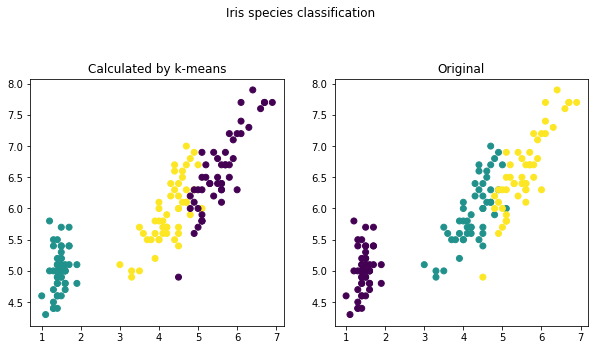

In [16]:
# Przygotowanie macierzy danych
irisDataOriginal = pd.read_csv("iris.csv")
irisData = irisDataOriginal.drop(columns = ['species'])

attributes = ['sepal_length', 'petal_length']

# Odszukanie najlepszego k metodą łokciową
maxk = 50
mink = 1
kRange = range(mink, maxk + 1)

distancesAverage = []
for k in kRange:
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(irisData)
    centroidy = kmeans.cluster_centers_
    
    distancesAverage.append(
        sum(np.min(cdist(irisData, centroidy, 'euclidean'), axis = 1)) / irisData.shape[0]
    ) 

plt.figure(figsize = (10,5))
plt.title('Average distance from centroid')
plt.xlabel('k')
plt.ylabel('Distance')

plt.plot(kRange, distancesAverage, 'bx-')
plt.show()

k = 3 # z wykresu

# Obliczenie grup metodą k-średnich
kmeans = KMeans(n_clusters = k, random_state = 0)
kmeans.fit(irisData)

groupsLabels = kmeans.fit_predict(irisData)

# Wydrukowanie wykresu metody k-średnich
plt.figure(figsize = (10,10))
plt.suptitle("Iris species classification")
plt.subplot(2, 2, 1)
plt.title("Calculated by k-means")
plt.scatter(
    irisData.petal_length, 
    irisData.sepal_length, 
    marker = 'o', 
    c = groupsLabels
)

# Wydrukowanie wykresu oryginału
plt.subplot(2, 2, 2)
plt.title("Original")
plt.scatter(
    irisDataOriginal.petal_length, 
    irisDataOriginal.sepal_length, 
    marker = 'o', 
    c = irisDataOriginal['species']
        .astype('category')
        .cat
        .codes
)

Wnioski z analizy wyników zad. 3:
* Z wykresu wynika, że punkt w którym rozpoczyna się spadek jest równy 2, podczas gdy rzeczywiście gatunków jest 3. Jest to konsekwencja tego, że dwa z trzech gatunków są do siebie bardzo zbliżone i gdyby rozróżnienie tych dwóch gatunków polegało tylko na długościach łodyg i płatków, to można byłoby bez większego błędu zakwalifikować tamte dwa gatunki jako jeden.
* Jest to nauka, żeby nie ograniczać analizy danych do tylko jednej metody i pary atrybutów.
* Ponieważ znamy rzeczywistą liczbę gatunktów, to założenie punktu dalej jako najbardziej optymalnego k, pozwoliło bezbłędnie zklasyfikować chyba każdy punkt (włącznie z pojedynczymi odpryskami).
* Dała zdecydowanie lepsze wyniki dla grup podobnych do siebie niż metoda aglomeracyjna. Choć sugerowała istnienie tylko dwóch gatunków, to pozwoliła z niesamowitą dokładnością rozróżnić trzeci gatunek, kiedy to zasugerowaliśmy.


> **Zadanie 4** Wygeneruj losowo zestaw transakcji w sklepie (15 produktów - "Produkt 1", "Produkt 2"...; 200 transakcji; ramka danych binarnych). Wyznacz dla przyjętych wartości wsparcia i ufności zestaw reguł asocjacyjnych dla tego zbioru.

In [17]:
# Przygotowanie listy możliwych produktów
transactionsAmount = 200
maxProductID = 15
minProductID = 1
productsRange = range(minProductID, maxProductID + 1)

products = []
for i in productsRange:
    products.append("Produkt %d" % i)

# Utworzenie zestawu transakcji w sposób losowy
shoppingData = pd.DataFrame(
    np.random.randint(0, 2, size = (transactionsAmount, maxProductID)),
    columns = products
)
shoppingData.index += 1

# Utworzenie zestawienia najpopularniejszych połączeń kupowanych produktów 
popularCombinations = apriori(
    shoppingData, 
    min_support = 0.2, 
    use_colnames = True
)

# Utworzenie reguł
productsAssociationsRules = association_rules(
    popularCombinations, 
    metric = "lift", 
    min_threshold = 1
)

# Przefiltrowanie reguł przez przyjęte wartości ufności i wsparcia
supportThreshold = 0.3
confidenceThreshold = 0.5

rulesFilteredByConfidence = productsAssociationsRules[
    (productsAssociationsRules['confidence'] >= confidenceThreshold)
]

rulesFilteredByConfidenceAndSupport = rulesFilteredByConfidence[
    (rulesFilteredByConfidence['support'] >= supportThreshold)
]

# Wyświetlenie najczęstrzych połączeń
rulesFilteredByConfidenceAndSupport


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
80,(Produkt 14),(Produkt 11),0.52,0.49,0.30,0.58,1.18,0.05,1.21
81,(Produkt 11),(Produkt 14),0.49,0.52,0.30,0.61,1.18,0.05,1.24
90,(Produkt 14),(Produkt 15),0.52,0.51,0.30,0.58,1.13,0.03,1.16
91,(Produkt 15),(Produkt 14),0.51,0.52,0.30,0.59,1.13,0.03,1.17


> **Zadanie 5** Zmień nazwę tego skryptu na następującą "PRiAD4_Imię_Nazwisko.ipynb" i wgraj wgraj go do ISOD-a we wskazane miejsce, nie przekraczając wyznaczonego terminu.